In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shap
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#read in the data
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_col.csv', index_col='CASEID')


In [3]:
#define anastomtoic leak as "y"
y_names=['COL_ANASTOMOTIC']

In [4]:
#name the colectomy-specific variables
cat = ['COL_INDICATION', 'COL_EMERGENT', 'COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC', 'COL_CHEMO','COL_APPROACH']
cont = []
features1 = cat + cont + y_names
#narrow the dataset to only include colectomy-specific variables
data = data[features1]
col = {'COL_INDICATION':'Indication', 'COL_EMERGENT':'Emergent indication', 'COL_STEROID':'Steroid use', 'COL_MECH_BOWEL_PREP':'Mechanical bowel prep', 'COL_ORAL_ANTIBIOTIC':'Antibiotic bowel prep', 'COL_CHEMO':'Chemotherapy','COL_APPROACH':'Approach'}

In [5]:
#rename variables to make figure more readable
data.rename(columns=col, inplace=True, errors='raise')

In [6]:
#define X and y
y = data['COL_ANASTOMOTIC']
X = data.drop(['COL_ANASTOMOTIC'], axis=1)

In [7]:
#split data into train/validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [8]:
#create a model based on only the colectomy specific variables
input_shape = [X.shape[1]]
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Flatten(input_shape=input_shape))
model4.add(tf.keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(tf.keras.layers.Dense(1000))
    model4.add(tf.keras.layers.BatchNormalization())
    model4.add(tf.keras.layers.Dropout(0.8))
    model4.add(tf.keras.layers.Activation("relu"))
model4.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)

metrics = [tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=1e-6,
    restore_best_weights=True,)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping])

Train on 155723 samples, validate on 38931 samples
Epoch 1/200
155723/155723 [==============================] - ETA: 0s - loss: 0.2527 - Sensitivity: 0.0417 - tn: 145505.0000 - auc: 0.5071 - prc: 0.0348

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


155723/155723 [==============================] - 4s 24us/sample - loss: 0.2527 - Sensitivity: 0.0417 - tn: 145505.0000 - auc: 0.5071 - prc: 0.0348 - val_loss: 0.1781 - val_Sensitivity: 0.0000e+00 - val_tn: 37630.0000 - val_auc: 0.6056 - val_prc: 0.0480
Epoch 2/200
155723/155723 [==============================] - 3s 18us/sample - loss: 0.1889 - Sensitivity: 0.0112 - tn: 149855.0000 - auc: 0.5238 - prc: 0.0378 - val_loss: 0.1684 - val_Sensitivity: 0.0000e+00 - val_tn: 37630.0000 - val_auc: 0.6164 - val_prc: 0.0520
Epoch 3/200
155723/155723 [==============================] - 3s 19us/sample - loss: 0.1733 - Sensitivity: 0.0025 - tn: 150194.0000 - auc: 0.5397 - prc: 0.0380 - val_loss: 0.1852 - val_Sensitivity: 0.0000e+00 - val_tn: 37630.0000 - val_auc: 0.6125 - val_prc: 0.0504
Epoch 4/200
155723/155723 [==============================] - 3s 19us/sample - loss: 0.1615 - Sensitivity: 0.0017 - tn: 150465.0000 - auc: 0.5566 - prc: 0.0406 - val_loss: 0.1926 - val_Sensitivity: 0.0000e+00 - val_tn:

model4.save('keras_col.h5')

model4 = tf.keras.models.load_model('keras_col.h5')

In [10]:
import shap

tf.config.list_physical_devices('GPU')

keras is no longer supported, please use tf.keras instead.


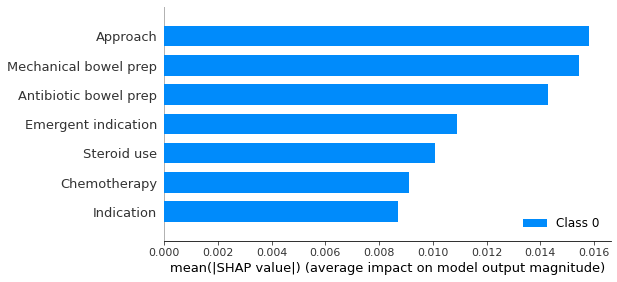

In [11]:
#generate the feature importance plot using SHAP deep explainer, sample values set to maximum to create robust results
#explainer requires numpy array rather than pandas dataframe -> .values
explainer = shap.DeepExplainer(model4, X_train.sample(n=5000))
shap_values = explainer.shap_values(X_valid.sample(n=5000).values)
shap.summary_plot(shap_values, X_valid.sample(n=5000))

In [12]:
shap_values[0].shape
vals = np.abs(shap_values[0]).mean(0)
feature_names = X_train.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(10)
feature_importance.to_excel('shap_col.xlsx')

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
coef = lr.coef_
ors = np.exp(coef)
ors = ors.squeeze()
or_df = pd.DataFrame(list(zip(X_train.columns, ors)),columns=['col_name','odds ratio'])
or_df['diff'] = abs(1 - or_df['odds ratio'])
or_df.sort_values(by='diff', ascending=False).to_excel('ors_hep.xlsx')